# Traduction Anglais-Français via un Transformer

Certains professeurs du département IPLN (Informatique Pour Les Nuls) ont des lacunes dans la langue de Shakespeare. Plutôt que de perdre leur temps à apprendre une langue, ils sont à la recherche d'un outil de traduction automatique offline. Ils proposent donc un projet à leurs étudiants.

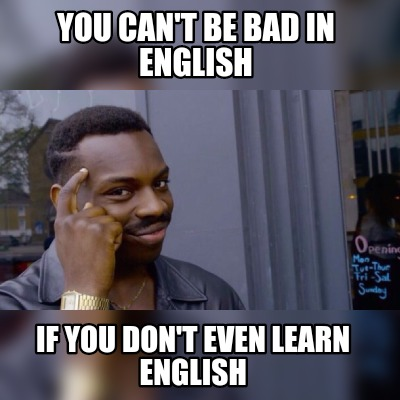

Dans ce TP, nous allons construire un modèle seq2seq, que nous entraînerons sur une tâche de traduction automatique de l'anglais vers le français.


# Prérequis

Assurez vous que le runtime utilise un GPU
**(Runtime/Change Runtime Type/Hardware accelerator/GPU)**


In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

# Dataset

In [ ]:
text_file = keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "fra.txt"


3432448/3423204 [==============================] - 0s 0us/step


Permet de vérifier que le dataset a bien été téléchargé et que le fichier de travail existe à l'adresse : /root/.keras/datasets/fra.txt

In [ ]:
%ls -la /root/.keras/datasets/

total 14756
drwxr-xr-x 2 root root     4096 Oct  7 12:24 ./
drwxr-xr-x 1 root root     4096 Oct  7 12:24 ../
-rw-r--r-- 1 root root     1441 Oct  7 12:24 _about.txt
-rw-r--r-- 1 root root  3423204 Oct  7 12:24 fra-eng.zip
-rw-r--r-- 1 root root 11669748 Oct  7 12:24 fra.txt


# Exercice 1 : Prétraitement

# Exercice 1.1 :

Chaque ligne contient une phrase anglaise et sa phrase française correspondante. La phrase anglaise est la séquence source et la phrase française est la séquence cible.

**Ajouter le jeton "[start]" et le jeton "[end]" aux phrases en français.**

Utiliser le code suivant pour vous aider :


In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
#@title insérez votre code ici

In [ ]:
#@title Résultat Attendu (avec des phrases aléatoires)
for _ in range(5):
    print(random.choice(text_pairs))

NameError: ignored

# Exercice 1.2 :

La séparation entre l'ensemble d'entraînement, de validation et de test, aussi connue sous le nom de "train-validation-test split," est une pratique courante en science des données pour évaluer et construire des modèles prédictifs. Elle implique de diviser un jeu de données en trois sous-ensembles distincts.

Réaliser une séparation en train/val/test avec le ratio suivant sur le dataset : 80/10/10

N.B. : pensez à modifier (randomiser) l'ordre des lignes dans le dataset avant la séparation

Résultat attendu

*   167130 lignes au total
*   133704 en train
*   16713  en validation
*   16713  en test



In [ ]:
#@title Insérer votre code ici
text_pairs = []
train_pairs = []
val_pairs = []
test_pairs = []
print(f"{len(text_pairs)} au total ")
print(f"{len(train_pairs)} en train")
print(f"{len(val_pairs)} en validation ")
print(f"{len(test_pairs)} en test ")

0 au total 
0 en train
0 en validation 
0 en test 


# Exercice 1.3

L'objectif est de transformer les séquences originales en séquences d'entiers où chaque entier représente l'index d'un mot dans un vocabulaire. (cf section du cours sur la tokenisation)

Pour cela, nous allons utiliser la classe [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization), en indiquant les informations suivantes :   

* taille du vocabulaire = 15000
* longueur max de la séquence = 20
* taille du batch = 64
* une fonction de normalisation "customisée", que nous allons implémenter

La fonction de normalisation

```
def custom_standardization(input_string):
```

des séquences doit avoir les critères suivants :

* elle prend en entrée une chaine de caractères
* Tous les caractères en sortie seront en minuscule (vous pouvez vous aider de la méthode de [tf.strings.lower](https://www.tensorflow.org/api_docs/python/tf/strings/lower)
* Suppression des ponctuations, à l'exception de "[" et "]" qui sont utilisés pour les tokens [start] et [end]. (voir les méthodes [string.punctuation](https://docs.python.org/3/library/string.html), [tf.strings.regex_replace](https://www.tensorflow.org/api_docs/python/tf/strings/lower), et [re.escape](https://docs.python.org/3/library/re.html))

In [ ]:
#@title Décommentez les lignes correspondant à eng/fra_vectorization pour créer vos instances de vectorisation

#insérez votre code ici

# eng_vectorization = TextVectorization(
#     max_tokens=vocab_size,
#     output_mode="int",
#     output_sequence_length=sequence_length,
#     standardize=custom_standardization,
# )

# fra_vectorization = TextVectorization(
#     max_tokens=vocab_size,
#     output_mode="int",
#     output_sequence_length=sequence_length+1,
#     standardize=custom_standardization,
# )

# Exercice 1.4

Appliquer la transformation sur votre dataset d'apprentissage (train), via la méthode  [TextVectorization.adapt()](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/)

Attention à bien distinguer la vectorization faite sur l'anglais et le français !

In [ ]:
#@title insérez votre code ici

# Construction du dataset après tokenisation

Nous allons maintenant formater nos jeux de données.

À chaque étape de l'apprentissage, le modèle cherchera à prédire les mots cibles N+1 (et au-delà) en utilisant la phrase source et les mots cibles 0 à N.

L'ensemble de données d'apprentissage produira un tuple (entrées, cibles), où :

* *inputs* est un dictionnaire avec les clés encoder_inputs et decoder_inputs.
* *encoder_inputs* est la phrase source vectorisée et encoder_inputs est la phrase cible "jusqu'ici", c'est-à-dire les mots 0 à N utilisés pour prédire le mot N+1 (et au-delà) dans la phrase cible.
* *target* est la phrase cible décalée d'une étape : elle fournit les mots suivants dans la phrase cible -- ce que le modèle va essayer de prédire.

In [ ]:
def format_dataset(eng, fra):
    eng = eng_vectorization(eng)
    fra = fra_vectorization(fra)
    return ({"encoder_inputs": eng, "decoder_inputs": fra[:, :-1],}, fra[:, 1:])


def make_dataset(pairs):
    eng_texts, fra_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fra_texts = list(fra_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fra_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
#@title Si tout s'est bien passé, le résultat est le suivant

for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

# Exercice 2 Construction du modèle

Notre modèle de séquence à séquence consiste en un TransformerEncoder et un TransformerDecoder enchaînés ensemble.

Pour que le modèle soit conscient de l'ordre des mots, nous utilisons également une couche PositionalEmbedding.


# Exercice 2.1

Finaliser la construction de l'encodeur en complétant le code ci-après et en s'aidant des informations suivantes :

*   __init__ est la méthode qui définit les attributs de la couche que l'on souhaite créer (cf [doc](https://keras.io/api/layers/base_layer/#layer-class))
*   **call** est la méthode permettant d'appliquer les différentes couches à notre entrée (cf [doc](https://keras.io/api/layers/base_layer/#layer-class))
* Notre encodeur contiendra les couches suivantes :

  * une couche [MultiHeadAttention](https://keras.io/api/layers/attention_layers/multi_head_attention/)
  * deux couches denses et deux couches de normalisation

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # insérez le code manquant

        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):

        # corrigez la ligne suivante
        attention_output = []
        proj_input = self.layernorm_1(inputs + attention_output) # On applique une normalisation pour stabiliser le réseau
        proj_output = self.dense_proj(proj_input) # Couche Dense permettant d'effectuer des tâches de classif ou regression (downstream tasks)
        return self.layernorm_2(proj_input + proj_output) # 2eme normalisation après couche dense

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [ ]:
#@title Le reste de l'architecture est donné ci-après. Notre objectif est maitenant de les assembler !

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.add = layers.Add()  # instead of `+` to preserve mask
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, use_causal_mask=True
        )
        out_1 = self.layernorm_1(self.add([inputs, attention_output_1]))

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
        )
        out_2 = self.layernorm_2(self.add([out_1, attention_output_2]))

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(self.add([out_2, proj_output]))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


# Exercice 2.2

Assembler l'encodeur, en intégrant les informations suivantes :

*   l'encodage *x* des positions de la séquence d'entrée, obtenu via la couche *PositionalEmbedding*
* la sortie de l'encodeur après le passage dans la couche *TransformerEncoder*

Les dimensions de l'entrée et des vecteurs latents, ainsi que le nombre de têtes (pour la MultiHeadAttention) sont donnés ci-après




In [ ]:
#@title Décommentez et complétez le code ici

# embed_dim = 256
# latent_dim = 2048
# num_heads = 8

# encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
# x =
# encoder_outputs =
# encoder = keras.Model(encoder_inputs, encoder_outputs)

# Exercice 2.3

Assembler le décodeur, en intégrant les informations suivantes :


*   l'encodage des positions de la séquence en entrée du décodeur (donc la séquence en français), obtenu via la couche PositionalEmbedding
*   l'entrée du decodeur inclue à la fois les sorties de l'encodeur et les sorties précédentes du décodeur



In [ ]:
#@title Complétez le code ici

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
# x =
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x) # permet d'obtenir une distribution de probabilité sur l'ensemble des tokens de notre vocabulaire
# decoder =

# decoder_outputs =

## Transformer Assemble !

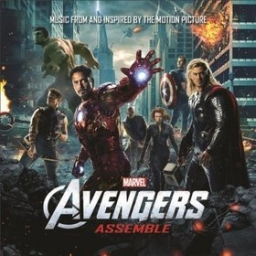

In [ ]:
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

# Exercice 2.4 :

Entraînez votre transformer jusqu'à convergence du réseau.
* Employez la fonction de coût suivante : *sparse_categorical_crossentropy*
* Employez la métrique suivante : *accuracy* (à noter que pour les traductions, le score BLEU est recommandé, mais il n'est pas nativement disponible sur Keras)
* Optionnel : vous pouvez utiliser la classe [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) pour stopper l'entraînement dès que la métrique observée ne s'améliore plus.
* Le choix de l'optimiseur est libre

In [ ]:
#@title Insérez votre code ici

# Exercice 2.5

Nous souhaitons maintenant tester notre modèle sur les phrases de tests.

Complétez la fonction suivante, qui prend en entrée la séquence en anglais et qui vous permettra d'obtenir la séquence décodée en français.


In [ ]:
#@title Complétez la fonction

fra_vocab = fra_vectorization.get_vocabulary()
fra_index_lookup = dict(zip(range(len(fra_vocab)), fra_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    # tokenized_input_sentence =
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = fra_vectorization([decoded_sentence])[:, :-1]
        # predictions =

        # sampled_token_index = TOKEN LE PLUS PROBABLE
        sampled_token = fra_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [ ]:
#@title Testez votre fonction en lançant cette cellule
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(f"ENG : {input_sentence}\n FR : {translated}")

# Exercice 2.6 (optionnel)

On constate que le modèle n'est pas très performant dans ses traductions. Donnez un ou plusieurs éléments qui pourrait expliquer cela.

In [ ]:
import nltk
nltk.download('punkt')  # Si vous n'avez pas déjà téléchargé les données nécessaires

from nltk.tokenize import word_tokenize, sent_tokenize

# Exemple de texte
text = "La tokenisation est un processus important en traitement du langage naturel. Elle divise le texte en mots et phrases."

# Tokenisation en mots
tokens_mots = word_tokenize(text)
print("Tokens en mots:")
print(tokens_mots)

# Tokenisation en phrases
tokens_phrases = sent_tokenize(text)
print("\nTokens en phrases:")
print(tokens_phrases)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Tokens en mots:
['La', 'tokenisation', 'est', 'un', 'processus', 'important', 'en', 'traitement', 'du', 'langage', 'naturel', '.', 'Elle', 'divise', 'le', 'texte', 'en', 'mots', 'et', 'phrases', '.']

Tokens en phrases:
['La tokenisation est un processus important en traitement du langage naturel.', 'Elle divise le texte en mots et phrases.']
